# Compare XCP to NR processed on the fly
* Load NR case
* Porcess data in TD and FD coprecessing frame
* Compare FD amp and dphase to XCP for l=2,3,4

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,get_xphm_coprec

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


In [2]:
# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s\n'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s\n'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s\n'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=False)

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation

(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/

(notebook)>> Lastly, we are currently on this branch: pnrv3-cp-bounded-dev

(notebook)>> We are not on the expected branch. This may cause unexpected behavior.


In [16]:
# Find a simulation
# a = scsearch(keyword='q8a08t150',verbose=True,catalog=calibration_catalog)[0]
a = scsearch(keyword='q8a08t90',verbose=True,catalog=calibration_catalog)[0]

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q8a08t90) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 1 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q8: 1chi0.80-p-q8.00	(q8a08t90dP0_T_96_384)



In [17]:
# Load data 
lmax=4
y = gwylm(a,lmax=lmax,verbose=False,clean=True,dt=0.5,pad=1000)

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.


In [18]:
#
kind='psi4'
frame = {}
frame['bam'] = y
frame['ji'] = y.__calc_initial_j_frame__()
frame['ji-sym'] = frame['ji'].__cpsymmetrize__(kind=kind,domain='td',hmclean=not True)
frame['td-cp'] = frame['ji-sym'].__calc_coprecessing_frame__(transform_domain='td',kind=kind).__symmetrize__(zparity=True)
frame['fd-cp-a'] = frame['ji-sym'].__calc_coprecessing_frame__(transform_domain='fd',select_lm_list=[(2,mm) for mm in range(-2,2+1)],kind=kind).__symmetrize__(zparity=True)
frame['fd-cp-b'] = frame['ji-sym'].__calc_coprecessing_frame__(transform_domain='fd',kind=kind).__symmetrize__(zparity=True)

(__rotate_frame_at_all_times__)>> TIME DOMAIN rotation specified
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
(__cpsymmetrize__)>> Using the Time Domain coprecessing frame for cleaning.
(__rotate_frame_at_all_times__)>> TIME DOMAIN rotation specified
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
(__calc_coprecessing_frame__)>> We will use psi4 to compute the co-precessing frame.
(__calc_coprecessing_frame__)>> Transforming to the coprecessing frame using TD angles.

In [19]:
#
frame['fd-cp-c'] = frame['ji-sym'].__calc_coprecessing_frame__(transform_domain='fd',select_lm_list=[(3,mm) for mm in range(-3,3+1)],kind=kind).__symmetrize__(zparity=True)

(__calc_radiated_linear_momentum__!)>> The current objects max ell value is 3, but we recommend a value of at least 4 for accurate determination of radiated linear momentum.
(calc_coprecessing_angles)>> The domain values seem evenly split between positive and negative values. Thus, we will interpret the input as corresponding to FREQUENCY DOMAIN data.
(calc_coprecessing_angles!)>> Flipping optimal emission direction so that beta is predominantly decreasing
(__rotate_frame_at_all_times__!)>> Note that metadata vectors for initial data will be rotated according to positive frequency angles.
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__!)>> Dynamics rotations will not be performed as FD angles given. There may be a way to determine the relevant TD angles
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have bee

In [20]:
#
ll,mm = 3,3

In [21]:
metadata_dict['simname'].index( y.simname )

79

### Evaluate Phenom Model Versions

In [22]:

#
lmlist = [(ll,mm)]
m1,m2 = y.m1,y.m2
simdex = metadata_dict['simname'].index( y.simname )
theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z = metadata_dict['array_data'][simdex]
chi1_vec = array([chi1_x,chi1_y,chi1_z])
chi2_vec = array([chi2_x,chi2_y,chi2_z])

#
x0,x1 = 0.015*mm,0.05*mm
model_f = linspace( x0, x1, 2000 )

#
tuned_xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( model_f,lmlist, m1, m2, chi1_vec, chi2_vec, pflag=500 )
tuned_xhm = tuned_xhm_dict[ll,ll]
tuned_xhm_amp = abs(tuned_xhm)
tuned_xhm_phi = unwrap( angle(tuned_xhm) )
tuned_xhm_dphi = spline_diff(model_f,tuned_xhm_phi)
tuned_xhm_dphi -= mean( tuned_xhm_dphi )

#
xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( model_f,lmlist, m1, m2, chi1_vec, chi2_vec, pflag=0 )
xhm = xhm_dict[ll,ll]
xhm_amp = abs(xhm)
xhm_phi = unwrap( angle(xhm) )
xhm_dphi = spline_diff(model_f,xhm_phi)
xhm_dphi -= mean( xhm_dphi )



### Compare multipole moments

Text(0.5, 1.0, 'q8a08t90dP0_T_96_384, $(\\ell,m)=(3,3)$, $\\ell_\\mathrm{max}=4$')

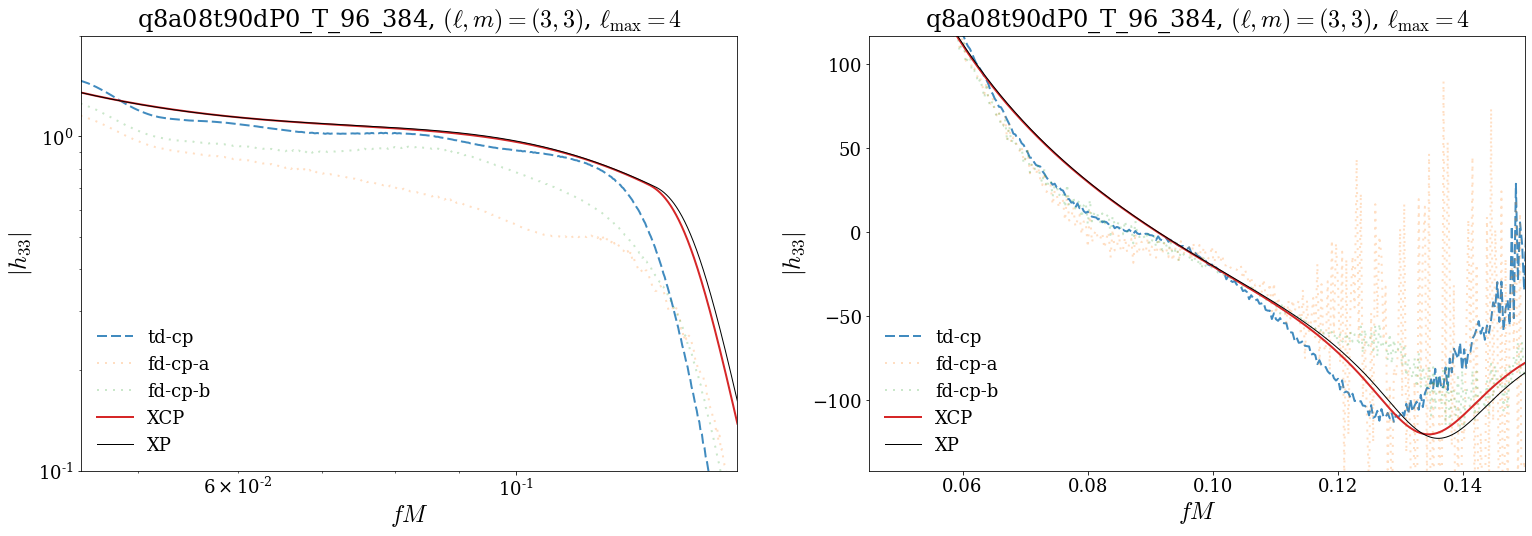

In [27]:


#
fig,ax = subplots( 1,2, figsize=2*figaspect(0.618/2) )
ax = ax.flatten()

#
keys = ['td-cp','fd-cp-a','fd-cp-b']
lw = 2
title_string = y.simname+r', $(\ell,m)=(%i,%i)$, $\ell_\mathrm{max}=%i$'%(ll,mm,lmax)

#
sca(ax[0])
for key in keys:
    plot( frame[key].f, frame[key][ll,mm]['strain'].fd_amp,label=key, ls='--' if key == 'td-cp' else ':',lw=lw, alpha=0.85 if key == 'td-cp' else 0.25 )
#
# plot( fJT, JT_amp, lw=lw, label='JT-XPNR' )
plot( model_f, tuned_xhm_amp, lw=lw, label='XCP',ls='-' )
plot( model_f, xhm_amp, lw=1, label='XP', color='k' )
#
sca(ax[1])
dphi_mask = (y.f>x0) & (y.f<x1)
center = lambda X: X - mean(X[ dphi_mask ])
center2 = lambda F,X: X - mean(X[ (F>x0) & (F<x1) ])
for key in keys:
    plot( frame[key].f, center(frame[key][ll,mm]['strain'].fd_dphi),label=key, ls='--' if key == 'td-cp' else ':',lw=lw, alpha=0.85 if key == 'td-cp' else 0.25 )
#
# plot( fJT, center2(fJT,JT_dphi), lw=lw, label='JT-XPNR' )
plot( model_f, center2(model_f,tuned_xhm_dphi), lw=lw, label='XCP', ls='-' )
plot( model_f, center2(model_f,xhm_dphi), lw=1, label='XP', color='k' )
# --- 
    
#
sca(ax[0])
xlim(x0,x1)
ylim( lim( frame['td-cp'][ll,mm]['strain'].fd_amp[(y.f>x0*0.9) & (y.f<x1)] ) )
ylim( 1e-1,2e0 )
yscale('log')
xscale('log')
legend()
xlabel('$fM$')
ylabel('$|h_{%i%i}|$'%(ll,mm))
title( title_string )

#
sca(ax[1])
xlim(x0,x1)
ylim( lim( center2(model_f,tuned_xhm_dphi)[(model_f>x0*1.4) & (model_f<x1)], dilate=0.1 ) )
legend()
xlabel('$fM$')
ylabel('$|h_{%i%i}|$'%(ll,mm))
title( title_string )




* Recall that FD coprecessing HMs are poorly behaved at low frequencies